# Data Visualization

### imports

In [4]:
from Audio_segmentation.concat_audio import produce_final_audio
from Audio_segmentation.split_audio import produce_audio_snippets
from db_connect import db_get_df
from dotenv import load_dotenv
import matplotlib.pyplot as plt
import mutagen.mp3
import os
from tqdm import tqdm

load_dotenv()
audiofile_path = os.getenv("AUDIO_SOURCE_PATH")

In [ ]:
df = db_get_df(table="transcripts_all")
print(len(df))
print(df.dtypes)

Wir verwenden hier das Deutsche model, um die deutschen Transkripte optimal zu encodieren.

### Audio file length

In [2]:
def get_mp3_lengths(directory):
    mp3_lengths = []
    for root, _, files in os.walk(directory):
        for file in files:
            if file.endswith(".mp3"):
                try:
                    file_path = os.path.join(root, file)
                    audio = mutagen.mp3.MP3(file_path)
                    mp3_lengths.append(audio.info.length)
                except:
                    print(f"file {file} corrupted")
    return mp3_lengths

def plot_mp3_lengths(mp3_lengths):
    plt.hist(mp3_lengths, bins=100, color='cornflowerblue', edgecolor='black')
    plt.xlabel('MP3 Länge (Sekungen)')
    plt.ylabel('Anzahl MP3 Datein')
    plt.title('Länge der MP3 Datein')
    plt.show()

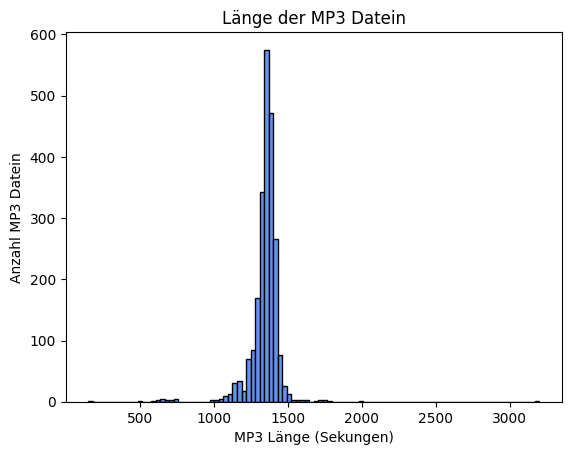

In [5]:
mp3_directory = audiofile_path
mp3_lengths = get_mp3_lengths(mp3_directory)
plot_mp3_lengths(mp3_lengths)


### Transcript length

In [ ]:
df = db_get_df(table="transcript_word_level_2237")

In [ ]:
filtered_df = df[df['filename'] == 'erich-fried-der-politische-lyriker.mp3']
filtered_df

In [ ]:
def plot_transcript_lengths(transcript_lengths):
    ax = plt.gca()
    ax.set_xlim([1500, 4000])
    plt.hist(transcript_lengths, bins=100, color='cornflowerblue', edgecolor='black')
    plt.xlabel('Transkript Länge (Wörter)')
    plt.ylabel('Anzahl  Transkripte')
    plt.title('Länge der Trankripte')
    plt.show()

In [ ]:
lengths = []
filenames = df["filename"].drop_duplicates(ignore_index=True)
for filename in tqdm(filenames):
    word_entries = df[df['filename'] == filename]
    lengths.append(len(word_entries))

In [ ]:
plot_transcript_lengths(lengths)

### Länge der Sätze

In [ ]:
df = db_get_df(table="transcript_sentences")

In [ ]:
def plot_sentence_lengths(sentence_lengths):
    plt.hist(sentence_lengths, bins=100, color='cornflowerblue', edgecolor='black')
    plt.xlabel('Sätze Länge (Wörter)')
    plt.ylabel('Anzahl  Sätze')
    plt.title('Länge der Sätze')
    plt.show()

In [ ]:
df["sentence_lenght"] = df["sentence"].apply(len)
df = df.sort_values(by="sentence_lenght")

In [ ]:
df.iloc[-1]["sentence"]

In [ ]:
df[df["sentence_lenght"] > 2000]

Logarithmische Normalverteilung

In [ ]:
plot_sentence_lengths(df[df["sentence_lenght"] < 500]["sentence_lenght"])

## Anzahl aller Episoden 

In [1]:
import requests 

GRAPHQL_URL = "https://api.ardaudiothek.de/graphql"
def get_graphql(query):
    response = requests.post(GRAPHQL_URL, json={"query": query})
    if response.status_code == 200:
        return response.json()
    else:
        raise f"GraphQL request failed with status code {response.status_code}"

In [ ]:
query = """
{
  programSet(id: [1, 5945518]) {
    title
    items(
      orderBy: PUBLISH_DATE_DESC
      filter: {
        isPublished: {
          equalTo: true
        }
      }
    ) {
      totalCount
    }
  }
}
"""

## Alle Autoren (nicht sprecher)

In [3]:
query = """
    {
        programSet(id: 5945518) {
        items(
            filter: {
            isPublished: {
                equalTo: true
            }
            }
        ) {
            nodes {
              description
            }
        }
        }
    }
"""

In [4]:
response = get_graphql(query)

In [27]:
[print(autor["description"].split("Autorin: ")[-1].split("Autor: ")[-1]) for autor in response["data"]["programSet"]["items"]["nodes"][:10]]

Frank Schüre
Beate Meierfrankenfeld
Karin Lamsfuß (BR 2020)
Daniela Remus
Carola Zinner
Karin Becker
Susanne Hofmann
Beate Meierfrankenfeld (BR 2018)
Martin Trauner (BR 2016)
Ulrike Beck


[None, None, None, None, None, None, None, None, None, None]

In [36]:
from tqdm import tqdm
autors = set()

for node in response["data"]["programSet"]["items"]["nodes"]:
    autor = node["description"]
    if "Autor: " in autor or "Autorin: " in autor:
        autor = autor.split("Autorin: ")[-1].split("Autor: ")[-1]
        autor = autor.split("(")[0]
    else:
        autor = ""
    autors.add(autor)

print(len(autors))

257
